# Libraries

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

import numpy as np

import matplotlib.pyplot as plt

import cv2
from PIL import Image

from torch import nn
from torchvision import transforms

import torch

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Visualization of Patches

## 1.1 Plot Sample Image

Sample is H = 224 and W = 224 pixels.


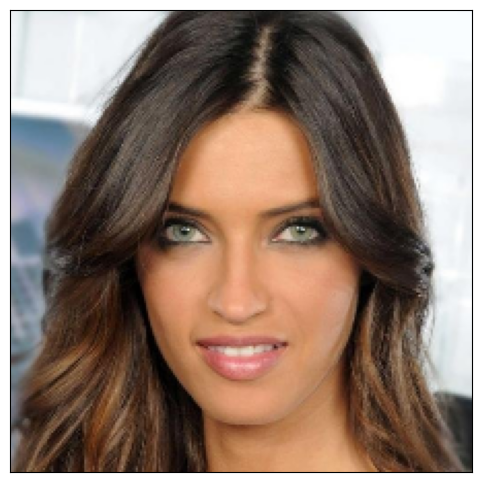

In [2]:
sample = cv2.imread("./sample.jpg")
shape = (224,224)
sample = cv2.resize(sample,shape)
sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)

H = sample.shape[0]
W = sample.shape[1]
print('Sample is H =', H, 'and W =', W, 'pixels.')

fig = plt.figure(figsize=(10,6))
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.show()

## 1.2 Num of Patches

In [3]:
aux = []
for i in range(1,H):
    if(H%i == 0):
        aux.append(i)
print(aux)

[1, 2, 4, 7, 8, 14, 16, 28, 32, 56, 112]


There will be 196 patches, each 16 by 16.




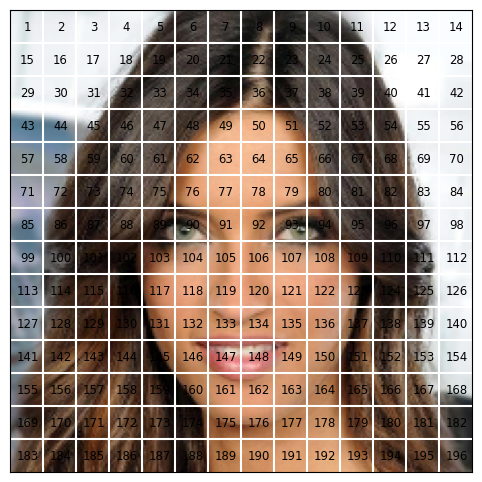

In [4]:
patch_size = 16
num_patches = int((H*W)/(patch_size**2))
print('There will be', num_patches, 'patches, each', patch_size, 'by', str(patch_size)+'.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(sample, cmap='Purples_r')
plt.hlines(np.arange(patch_size, H, patch_size)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(patch_size, W, patch_size)-0.5, -0.5, H-0.5, color='w')
plt.xticks([])
plt.yticks([])

text = np.linspace(int(patch_size/2), W - int(patch_size/2), int(num_patches**0.5))

num = 1
for text_i in text:
    for text_j in text:
        plt.text(text_j,text_i, str(num), color='black', fontsize='small', ha='center',va='center')
        num +=1
#plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');
#plt.savefig(os.path.join(figure_path, 'mountain_patches.png'), bbox_inches='tight'

# 2. Patch Tokenization

In [4]:
class Patch_Tokenization(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 1, 60, 100),
                patch_size: int=50,
                token_len: int=768):

        """ Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        B, C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H / self.patch_size) * (W / self.patch_size)

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        x = self.split(x).transpose(2,1)
        x = self.project(x)
        return x

## 2.1 Applying tokenize

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize the image to 256x256 pixels
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [3]:
image = Image.open("./sample.jpg")


image_transform = transform(image)
image_transform = image_transform.unsqueeze(0)
image_transform = torch.cat([image_transform]*7)

In [8]:
patch_tokenization = Patch_Tokenization(
    img_size=image_transform.shape,
    patch_size=patch_size,
    token_len=512
)
image_token = patch_tokenization(image_transform)

#image_token = 

print(image_token.shape)
print(image_token)

torch.Size([7, 196, 512])
tensor([[[ 0.3288, -0.3169,  0.1879,  ...,  0.7731,  0.2542,  1.5354],
         [ 0.4269, -0.3178,  0.2672,  ...,  0.7063,  0.2499,  1.5707],
         [ 0.4032, -0.3315,  0.2113,  ...,  0.7855,  0.2473,  1.6297],
         ...,
         [-0.5581,  0.1047, -0.1132,  ..., -0.3667, -0.2127, -0.6632],
         [ 0.2351,  0.1725,  0.0429,  ..., -0.5896,  0.0261, -0.7136],
         [ 0.0610,  0.1645, -0.0190,  ..., -0.4334, -0.2507, -0.5641]],

        [[ 0.3288, -0.3169,  0.1879,  ...,  0.7731,  0.2542,  1.5354],
         [ 0.4269, -0.3178,  0.2672,  ...,  0.7063,  0.2499,  1.5707],
         [ 0.4032, -0.3315,  0.2113,  ...,  0.7855,  0.2473,  1.6297],
         ...,
         [-0.5581,  0.1047, -0.1132,  ..., -0.3667, -0.2127, -0.6632],
         [ 0.2351,  0.1725,  0.0429,  ..., -0.5896,  0.0261, -0.7136],
         [ 0.0610,  0.1645, -0.0190,  ..., -0.4334, -0.2507, -0.5641]],

        [[ 0.3288, -0.3169,  0.1879,  ...,  0.7731,  0.2542,  1.5354],
         [ 0.4269, 

# 3. Build Vision Transformer Model

In [78]:
def get_sinusoid_encoding(num_tokens, token_len):
        """ Make Sinusoid Encoding Table
    
            Args:
                num_tokens (int): number of tokens
                token_len (int): length of a token
                
            Returns:
                (torch.FloatTensor) sinusoidal position encoding table
        """
    
        def get_position_angle_vec(i):
            return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]
    
        sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 
    
        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class Patch_Tokenization(nn.Module):
    def __init__(self,
                patch_size: int=50,
                token_len: int=768,
                channels: int=3):

        """ Patch Tokenization Module
            Args:
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()
        self.patch_size = patch_size
        self.token_len = token_len
        self.channels = channels

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*self.channels, token_len)

    def forward(self, x):
        x = self.split(x).transpose(2,1)
        x = self.project(x)
        return x

class VisionModel(nn.Module):
    def __init__(self, img_size, patch_size, token_len, embed_dim=512, num_heads=8, num_layers=6):
        super(VisionModel, self).__init__()
        
        ## Defining Parameters
        self.img_size = img_size
        B, C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H // self.patch_size) * (W // self.patch_size)
        
        self.patch_tokenization = Patch_Tokenization(
                patch_size=patch_size,
                token_len=token_len,
                channels=C
            )
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        self.emb_posi = nn.Parameter(
            data=get_sinusoid_encoding(self.num_tokens+1, self.token_len),
            requires_grad=False
        )

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.linear = nn.Linear(self.token_len,(self.patch_size**2)*C)
        self.final_layer = nn.Linear((self.patch_size**2)*C,C*H*W)
        #self.fold = nn.Fold(output_size=(H, W), kernel_size=(self.patch_size,self.patch_size),stride=(self.patch_size,self.patch_size))

    
    def forward(self,x):
        image_token = self.patch_tokenization(x)
        
        B, N, E = image_token.shape
        tokens = self.cls_token.expand(B,-1,-1)
        image_token = torch.cat((tokens,image_token),dim=1)
        image_token += self.emb_posi
        image_token = image_token.permute(1,0,2)

        out_encode = self.transformer_encoder(image_token)

        # Transformer decoder
        #decoder_input = self.linear(out_encode[0])  # Take the cls token output (1, B, E)
        decoder_input = out_encode[0,:,:]
        decoder_input = decoder_input.unsqueeze(0)  # Add a time dimension
        decoder_output = self.transformer_decoder(out_encode, decoder_input)  # (N, B, E)
        
        # Final linear layer for image reconstruction
        x = decoder_output[0,:,:]
        x = self.linear(x)
        x = self.final_layer(x)

        _, C, H, W = self.img_size
        
        x = x.reshape(-1,C,H,W)
        
        
        return x
        
        #return out_encode

## 3.1 Applying model

In [79]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize the image to 256x256 pixels
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

image = Image.open("./sample.jpg")


image_transform = transform(image)
image_transform = image_transform.unsqueeze(0)
image_transform = torch.cat([image_transform]*7)

In [80]:
vision_model = VisionModel(img_size=(7,3,224,224),patch_size=16,token_len=512)

In [81]:
out = vision_model(image_transform)

In [82]:
out.shape

torch.Size([7, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


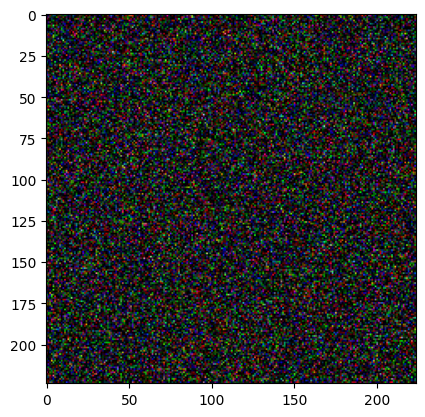

In [83]:
plt.imshow(out[0].permute(1, 2, 0).detach().numpy())